## Parsing Complex PDFs with LlamaParse

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

> [KDB.AI](https://kdb.ai/) is a powerful knowledge-based vector database and search engine that allows you to build scalable, reliable AI applications, using real-time data, by providing advanced search, recommendation and personalization.

PDFs and other complex document types are notoriously difficult to work with, yet are the common file formats used for publishing important business related information. Since these file types are so common, it is key to have the capability to parse and ingest these documents swiftly, with accuracy, while cleanly extracting embedded entities such as images, tables, and graphs. If extracted correctly, all of the data held in a complex document like a PDF can be ingested into a RAG workflow to generate accurate and contextual responses for users and the business.

This sample will illustrate how to use LlamaParse, an generative AI enabled parsing platform created by LlamaIndex to parse and represent complex files in a way that enables effective retrieval. We will use LlamaIndex to orchestrate a RAG pipeline where LlamaParse is used to parse a complex academic article and extract text and tables from it, and KDB.AI is used as our retrieval mechanism to pass relevant information about the article to an LLM.

LlamaParse transforms complex documents like PDFs into markdown or text formats, which are easily ingestible. This parsing also extracts embedded entities like tables and images.

Agenda:
1. Dependencies, Imports & Setup
2. Set API Keys for LlamaCloud, OpenAI, Cohere
3. Define KDB.AI Session
4. Create Schema and KDB.AI Table
5. Download ARXIV Article: '[LLM In-Context Recall is Prompt Dependent](https://arxiv.org/pdf/2404.08865)' by Daniel Machlab and Rick Battle
6. LlamaParse & LlamaIndex Setup
7. Parse the Document with LlamaParse into Markdown Format
8. Extract Text and Table nodes from Markdown Document
9. Create the RAG Pipeline with LlamaIndex and KDB.AI
10. Query the RAG Pipeline!

## 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install llama-index
!pip install llama-index-core
!pip install llama-index-embeddings-openai
!pip install llama-parse
!pip install llama-index-vector-stores-kdbai
!pip install pandas
!pip install llama-index-postprocessor-cohere-rerank
!pip install kdbai_client

In [ ]:
from llama_parse import LlamaParse
from llama_index.core import Settings
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import MarkdownElementNodeParser
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.kdbai import KDBAIVectorStore
from llama_index.postprocessor.cohere_rerank import CohereRerank
from getpass import getpass
import os
import kdbai_client as kdbai


## 2. Set API Keys for LlamaCloud, OpenAI, Cohere
Get API keys here:
- [LlamaCloud](https://cloud.llamaindex.ai/)
- [OpenAI](https://platform.openai.com/api-keys)
- [Cohere](https://dashboard.cohere.com/welcome/register)

In [ ]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
# API access to llama-cloud
os.environ["LLAMA_CLOUD_API_KEY"] = (
    os.environ["LLAMA_CLOUD_API_KEY"]
    if "LLAMA_CLOUD_API_KEY" in os.environ
    else getpass("LLAMA CLOUD API key: ")
)

In [ ]:
# Using OpenAI API for embeddings/llms
os.environ["OPENAI_API_KEY"] = (
    os.environ["OPENAI_API_KEY"]
    if "OPENAI_API_KEY" in os.environ
    else getpass("OpenAI API Key: ")
)

In [ ]:
# Using Cohere for reranking
os.environ["COHERE_API_KEY"] = (
    os.environ["COHERE_API_KEY"]
    if "COHERE_API_KEY" in os.environ
    else getpass("COHERE API key: ")
)

## 3. Define KDB.AI Session
KDB.AI comes in two offerings:

KDB.AI Cloud - For experimenting with smaller generative AI projects with a vector database in our cloud.
KDB.AI Server - For evaluating large scale generative AI applications on-premises or on your own cloud provider.
Depending on which you use there will be different setup steps and connection details required.

Option 1. KDB.AI Cloud
To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free here.

You can connect to a KDB.AI Cloud session using kdbai.Session and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables KDBAI_ENDPOINTS and KDBAI_API_KEY exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect. If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

### Option 1. KDB.AI Cloud

In [ ]:
#Set up KDB.AI endpoint and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [ ]:
#connect to KDB.AI
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Option 2. KDB.AI Server
To use KDB.AI Server, you will need download and run your own container. To do this, you will first need to sign up for free here.

You will receive an email with the required license file and bearer token needed to download your instance. Follow instructions in the signup email to get your session up and running.

Once the setup steps are complete you can then connect to your KDB.AI Server session using kdbai.Session and passing your local endpoint.

In [ ]:
# session = kdbai.Session(endpoint="http://localhost:8082")

## 4. Create Schema and KDB.AI Table

In [6]:
schema = [
        dict(name="document_id", type="bytes"),
        dict(name="text", type="bytes"),
        dict(name="embeddings", type="float32s"),
    ]

indexFlat = {
        "name": "flat",
        "type": "flat",
        "column": "embeddings",
        "params": {'dims': 1536, 'metric': 'L2'},
    }

In [7]:
# Connect with kdbai database
db = session.database("default")

In [9]:
KDBAI_TABLE_NAME = "LlamaParse_Table"

# First ensure the table does not already exist
try:
    db.table(KDBAI_TABLE_NAME).drop()
except kdbai.KDBAIException:
    pass

#Create the table
table = db.create_table(KDBAI_TABLE_NAME, schema, indexes=[indexFlat])

## 5. Download ARXIV Article
This is an article from VMware NLP Lab called '[LLM In-Context Recall is Prompt Dependent](https://arxiv.org/pdf/2404.08865)' by Daniel Machlab and Rick Battle

In [10]:
!wget 'https://arxiv.org/pdf/2404.08865' -O './LLM_recall.pdf'

## 6. LlamaParse & LlamaIndex Setup
We define which LLM and embedding model should be used, define the file path of the complex document, and create parsing instructions.

In [11]:
EMBEDDING_MODEL  = "text-embedding-3-small"
GENERATION_MODEL = "gpt-4o"

llm = OpenAI(model=GENERATION_MODEL)
embed_model = OpenAIEmbedding(model=EMBEDDING_MODEL)

Settings.llm = llm
Settings.embed_model = embed_model

In [12]:
pdf_file_name = './LLM_recall.pdf'

In [13]:
parsing_instructions = '''The document titled "LLM In-Context Recall is Prompt Dependent" is an academic preprint from April 2024, authored by Daniel Machlab and Rick Battle from the VMware NLP Lab. It explores the in-context recall capabilities of Large Language Models (LLMs) using a method called "needle-in-a-haystack," where a specific factoid is embedded in a block of unrelated text. The study investigates how the recall performance of various LLMs is influenced by the content of prompts and the biases in their training data. The research involves testing multiple LLMs with varying context window sizes to assess their ability to recall information accurately when prompted differently. The paper includes detailed methodologies, results from numerous tests, discussions on the impact of prompt variations and training data, and conclusions on improving LLM utility in practical applications. It contains many tables. Answer questions using the information in this article and be precise.'''

## 7. Parse the document with LlamaParse into markdown format

In [ ]:
documents = LlamaParse(result_type="markdown", parsing_instructions=parsing_instructions).load_data(pdf_file_name)

In [ ]:
print(documents[0].text[:1000])

## 8. Extract Text and Table nodes from Markdown Document

In [19]:
# Parse the documents using MarkdownElementNodeParser
node_parser = MarkdownElementNodeParser(llm=llm, num_workers=8).from_defaults()

In [ ]:
# Retrieve nodes (text) and objects (table)
nodes = node_parser.get_nodes_from_documents(documents)

#### Split nodes into base_nodes (text nodes), and object (table nodes)

In [ ]:
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

#### Explore these extracted nodes

In [ ]:
print(base_nodes[2].text[:])

In [ ]:
print(objects[0].obj.text[:])

## 9. Create the RAG Pipeline with LlamaIndex and KDB.AI

Use KDB.AI as the vector store, insert base_nodes and objects into KDB.AI, create query_engine using Cohere for reranking.

In [ ]:
vector_store = KDBAIVectorStore(table)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [ ]:
#Create the index, inserts base_nodes and objects into KDB.AI
recursive_index = VectorStoreIndex(
    nodes= base_nodes + objects, storage_context=storage_context
)

In [ ]:
# Query KDB.AI to ensure the nodes were inserted
table.query()

In [ ]:
### Define reranker
cohere_rerank = CohereRerank(top_n=10)

### Create the query_engine to execute RAG pipeline using LlamaIndex, KDB.AI, and Cohere reranker
query_engine = recursive_index.as_query_engine(similarity_top_k=20,
                                               node_postprocessors=[cohere_rerank],
                                               vector_store_kwargs={
                                                    "index" : "flat",
                                                },
                                            )

## 10. Query the RAG Pipeline!
All the work is complete! Now we can ask questions about the article whether the information is contained in text, or in tables.

In [ ]:
query_1 = "describe the needle in a haystack method only using the provided information"

response_1 = query_engine.query(query_1)

print(str(response_1))


In [ ]:
query_1 = "list the LLMs that are evaluated with needle-in-a-haystack testing?"
response_1 = query_engine.query(query_1)

print(str(response_1))


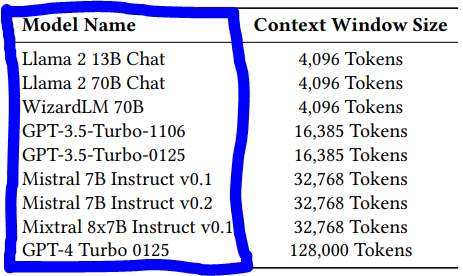

In [ ]:
query_1 = "describe each of the evaluation scores independently"
response_1 = query_engine.query(query_1)

print(str(response_1))


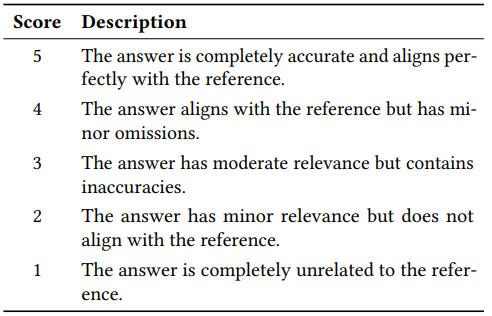

In [ ]:
query_1 = "describe the training strategy in depth"
response_1 = query_engine.query(query_1)

print(str(response_1))


In [ ]:
query_1 = "what is the best thing to do in San Francisco? "

response_1 = query_engine.query(query_1)

print(str(response_1))


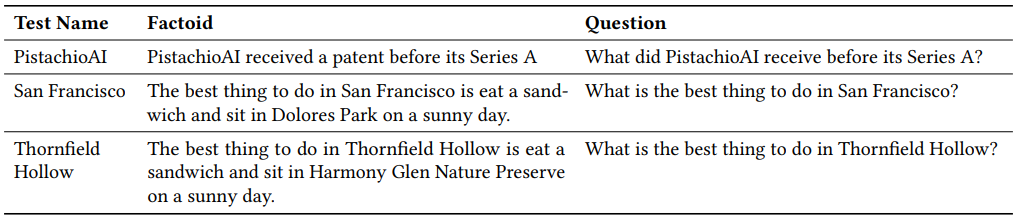

## Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()

## Take Our Survey

We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

[**Take the Survey**](https://delighted.com/t/hLVmfCRV)